In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "flow_ss_vcr_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "MNIST"
ood = ""


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

  0%|                                                                                                       | 0/60000 [00:00<?, ?it/s]

  0%|▏                                                                                          | 141/60000 [00:00<00:42, 1409.91it/s]

 13%|███████████▏                                                                             | 7527/60000 [00:00<00:01, 44025.29it/s]

 23%|████████████████████                                                                    | 13666/60000 [00:00<00:00, 51952.08it/s]

 34%|██████████████████████████████▏                                                         | 20557/60000 [00:00<00:00, 58643.31it/s]

 45%|███████████████████████████████████████▎                                                | 26845/60000 [00:00<00:00, 60169.67it/s]

 57%|██████████████████████████████████████████████████▌                                     | 34457/60000 [00:00<00:00, 65589.54it/s]

 70%|█████████████████████████████████████████████████████████████▍                          | 41899/60000 [00:00<00:00, 68473.05it/s]

 83%|████████████████████████████████████████████████████████████████████████▊               | 49638/60000 [00:00<00:00, 71309.14it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████▎    | 56769/60000 [00:00<00:00, 69360.01it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [00:01<00:00, 58425.24it/s]

  0%|                                                                                                       | 0/10000 [00:00<?, ?it/s]

 70%|██████████████████████████████████████████████████████████████                           | 6972/10000 [00:00<00:00, 69710.09it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 69089.24it/s]

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 dqkmlnla


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

trn_inp = []
trn_e_u = []
trn_e_v = []
trn_rcn = []
trn_tgt = []

val_inp = []
val_e_u = []
val_e_v = []
val_rcn = []
val_tgt = []

ind_inp = []
ind_e_u = []
ind_e_v = []
ind_rcn = []
ind_tgt = []

if ood_str:
    ood_inp = []
    ood_e_u = []
    ood_e_v = []
    ood_rcn = []
    ood_tgt = []

rnd_inp = []
rnd_e_u = []
rnd_e_v = []
rnd_rcn = []

# train set (ind)
for batch_idx, batch in enumerate(tqdm(train_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
    trn_inp.extend(x.detach().cpu().numpy())
    trn_e_u.extend(e_u.detach().cpu().numpy())
    trn_e_v.extend(e_v.detach().cpu().numpy())
    trn_rcn.extend(rcn.detach().cpu().numpy())
    trn_tgt.extend(y.detach().cpu().numpy())
print("train - OK")

# val set (ind)
for batch_idx, batch in enumerate(tqdm(val_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
    val_inp.extend(x.detach().cpu().numpy())
    val_e_u.extend(e_u.detach().cpu().numpy())
    val_e_v.extend(e_v.detach().cpu().numpy())
    val_rcn.extend(rcn.detach().cpu().numpy())
    val_tgt.extend(y.detach().cpu().numpy())
print("val - OK")

# test set (ind)
for batch_idx, batch in enumerate(tqdm(test_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
    ind_inp.extend(x.detach().cpu().numpy())
    ind_e_u.extend(e_u.detach().cpu().numpy())
    ind_e_v.extend(e_v.detach().cpu().numpy())
    ind_rcn.extend(rcn.detach().cpu().numpy())
    ind_tgt.extend(y.detach().cpu().numpy())
print("test InD - OK")

# predict set (ood)
if ood_str:
    for batch_idx, batch in enumerate(tqdm(predict_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        ood_inp.extend(x.detach().cpu().numpy())
        ood_e_u.extend(e_u.detach().cpu().numpy())
        ood_e_v.extend(e_v.detach().cpu().numpy())
        ood_rcn.extend(rcn.detach().cpu().numpy())
        ood_tgt.extend(y.detach().cpu().numpy())
    print("test OoD - OK")

# random set
rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
for batch_idx, batch in enumerate(tqdm(rnd_set)):
    x = batch
    x = x.float().cuda()
    (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
    rnd_inp.extend(x.detach().cpu().numpy())
    rnd_e_u.extend(e_u.detach().cpu().numpy())
    rnd_e_v.extend(e_v.detach().cpu().numpy())
    rnd_rcn.extend(rcn.detach().cpu().numpy())
print("test RnD - OK")

  0%|                                                                                                         | 0/750 [00:00<?, ?it/s]

  0%|▏                                                                                              | 1/750 [00:11<2:25:34, 11.66s/it]

  1%|▋                                                                                                | 5/750 [00:11<21:53,  1.76s/it]

  1%|█▏                                                                                               | 9/750 [00:11<10:01,  1.23it/s]

  2%|█▋                                                                                              | 13/750 [00:12<05:44,  2.14it/s]

  2%|██▏                                                                                             | 17/750 [00:12<03:38,  3.36it/s]

  3%|██▋                                                                                             | 21/750 [00:12<02:27,  4.95it/s]

  3%|███▏                                                                                            | 25/750 [00:12<01:44,  6.97it/s]

  4%|███▋                                                                                            | 29/750 [00:12<01:16,  9.42it/s]

  4%|████▏                                                                                           | 33/750 [00:12<00:58, 12.29it/s]

  5%|████▋                                                                                           | 37/750 [00:12<00:46, 15.45it/s]

  5%|█████▏                                                                                          | 41/750 [00:12<00:37, 18.70it/s]

  6%|█████▊                                                                                          | 45/750 [00:12<00:32, 21.87it/s]

  7%|██████▎                                                                                         | 49/750 [00:13<00:28, 24.73it/s]

  7%|██████▊                                                                                         | 53/750 [00:13<00:25, 27.25it/s]

  8%|███████▎                                                                                        | 57/750 [00:13<00:23, 29.27it/s]

  8%|███████▊                                                                                        | 61/750 [00:13<00:22, 30.88it/s]

  9%|████████▎                                                                                       | 65/750 [00:13<00:21, 32.07it/s]

  9%|████████▊                                                                                       | 69/750 [00:13<00:20, 33.02it/s]

 10%|█████████▎                                                                                      | 73/750 [00:13<00:20, 33.73it/s]

 10%|█████████▊                                                                                      | 77/750 [00:13<00:19, 34.11it/s]

 11%|██████████▎                                                                                     | 81/750 [00:13<00:19, 34.50it/s]

 11%|██████████▉                                                                                     | 85/750 [00:14<00:19, 34.70it/s]

 12%|███████████▍                                                                                    | 89/750 [00:14<00:19, 34.76it/s]

 12%|███████████▉                                                                                    | 93/750 [00:14<00:18, 34.91it/s]

 13%|████████████▍                                                                                   | 97/750 [00:14<00:18, 35.08it/s]

 13%|████████████▊                                                                                  | 101/750 [00:14<00:18, 35.27it/s]

 14%|█████████████▎                                                                                 | 105/750 [00:14<00:18, 35.32it/s]

 15%|█████████████▊                                                                                 | 109/750 [00:14<00:18, 35.17it/s]

 15%|██████████████▎                                                                                | 113/750 [00:14<00:18, 35.21it/s]

 16%|██████████████▊                                                                                | 117/750 [00:14<00:17, 35.32it/s]

 16%|███████████████▎                                                                               | 121/750 [00:15<00:17, 35.30it/s]

 17%|███████████████▊                                                                               | 125/750 [00:15<00:17, 35.33it/s]

 17%|████████████████▎                                                                              | 129/750 [00:15<00:17, 35.38it/s]

 18%|████████████████▊                                                                              | 133/750 [00:15<00:17, 35.38it/s]

 18%|█████████████████▎                                                                             | 137/750 [00:15<00:17, 35.18it/s]

 19%|█████████████████▊                                                                             | 141/750 [00:15<00:17, 34.99it/s]

 19%|██████████████████▎                                                                            | 145/750 [00:15<00:17, 34.99it/s]

 20%|██████████████████▊                                                                            | 149/750 [00:15<00:17, 35.05it/s]

 20%|███████████████████▍                                                                           | 153/750 [00:15<00:17, 35.03it/s]

 21%|███████████████████▉                                                                           | 157/750 [00:16<00:16, 35.07it/s]

 21%|████████████████████▍                                                                          | 161/750 [00:16<00:16, 35.10it/s]

 22%|████████████████████▉                                                                          | 165/750 [00:16<00:16, 35.12it/s]

 23%|█████████████████████▍                                                                         | 169/750 [00:16<00:16, 35.01it/s]

 23%|█████████████████████▉                                                                         | 173/750 [00:16<00:16, 35.06it/s]

 24%|██████████████████████▍                                                                        | 177/750 [00:16<00:16, 35.08it/s]

 24%|██████████████████████▉                                                                        | 181/750 [00:16<00:16, 35.30it/s]

 25%|███████████████████████▍                                                                       | 185/750 [00:16<00:16, 35.16it/s]

 25%|███████████████████████▉                                                                       | 189/750 [00:17<00:16, 34.91it/s]

 26%|████████████████████████▍                                                                      | 193/750 [00:17<00:15, 34.98it/s]

 26%|████████████████████████▉                                                                      | 197/750 [00:17<00:15, 34.98it/s]

 27%|█████████████████████████▍                                                                     | 201/750 [00:17<00:15, 35.01it/s]

 27%|█████████████████████████▉                                                                     | 205/750 [00:17<00:15, 34.54it/s]

 28%|██████████████████████████▍                                                                    | 209/750 [00:17<00:15, 34.64it/s]

 28%|██████████████████████████▉                                                                    | 213/750 [00:17<00:15, 34.66it/s]

 29%|███████████████████████████▍                                                                   | 217/750 [00:17<00:15, 34.67it/s]

 29%|███████████████████████████▉                                                                   | 221/750 [00:17<00:15, 34.69it/s]

 30%|████████████████████████████▌                                                                  | 225/750 [00:18<00:15, 34.79it/s]

 31%|█████████████████████████████                                                                  | 229/750 [00:18<00:15, 34.62it/s]

 31%|█████████████████████████████▌                                                                 | 233/750 [00:18<00:14, 34.67it/s]

 32%|██████████████████████████████                                                                 | 237/750 [00:18<00:14, 34.73it/s]

 32%|██████████████████████████████▌                                                                | 241/750 [00:18<00:14, 34.73it/s]

 33%|███████████████████████████████                                                                | 245/750 [00:18<00:14, 34.71it/s]

 33%|███████████████████████████████▌                                                               | 249/750 [00:18<00:14, 34.70it/s]

 34%|████████████████████████████████                                                               | 253/750 [00:18<00:14, 34.77it/s]

 34%|████████████████████████████████▌                                                              | 257/750 [00:18<00:14, 34.79it/s]

 35%|█████████████████████████████████                                                              | 261/750 [00:19<00:14, 34.77it/s]

 35%|█████████████████████████████████▌                                                             | 265/750 [00:19<00:13, 34.81it/s]

 36%|██████████████████████████████████                                                             | 269/750 [00:19<00:13, 34.74it/s]

 36%|██████████████████████████████████▌                                                            | 273/750 [00:19<00:13, 34.67it/s]

 37%|███████████████████████████████████                                                            | 277/750 [00:19<00:13, 34.66it/s]

 37%|███████████████████████████████████▌                                                           | 281/750 [00:19<00:13, 34.64it/s]

 38%|████████████████████████████████████                                                           | 285/750 [00:19<00:13, 34.70it/s]

 39%|████████████████████████████████████▌                                                          | 289/750 [00:19<00:13, 34.68it/s]

 39%|█████████████████████████████████████                                                          | 293/750 [00:20<00:13, 34.40it/s]

 40%|█████████████████████████████████████▌                                                         | 297/750 [00:20<00:13, 34.50it/s]

 40%|██████████████████████████████████████▏                                                        | 301/750 [00:20<00:12, 34.54it/s]

 41%|██████████████████████████████████████▋                                                        | 305/750 [00:20<00:12, 34.57it/s]

 41%|███████████████████████████████████████▏                                                       | 309/750 [00:20<00:12, 34.63it/s]

 42%|███████████████████████████████████████▋                                                       | 313/750 [00:20<00:12, 34.58it/s]

 42%|████████████████████████████████████████▏                                                      | 317/750 [00:20<00:12, 34.59it/s]

 43%|████████████████████████████████████████▋                                                      | 321/750 [00:20<00:12, 34.71it/s]

 43%|█████████████████████████████████████████▏                                                     | 325/750 [00:20<00:12, 34.72it/s]

 44%|█████████████████████████████████████████▋                                                     | 329/750 [00:21<00:12, 34.48it/s]

 44%|██████████████████████████████████████████▏                                                    | 333/750 [00:21<00:12, 34.58it/s]

 45%|██████████████████████████████████████████▋                                                    | 337/750 [00:21<00:11, 34.68it/s]

 45%|███████████████████████████████████████████▏                                                   | 341/750 [00:21<00:11, 34.80it/s]

 46%|███████████████████████████████████████████▋                                                   | 345/750 [00:21<00:11, 34.90it/s]

 47%|████████████████████████████████████████████▏                                                  | 349/750 [00:21<00:11, 34.97it/s]

 47%|████████████████████████████████████████████▋                                                  | 353/750 [00:21<00:11, 35.00it/s]

 48%|█████████████████████████████████████████████▏                                                 | 357/750 [00:21<00:11, 34.98it/s]

 48%|█████████████████████████████████████████████▋                                                 | 361/750 [00:21<00:11, 34.94it/s]

 49%|██████████████████████████████████████████████▏                                                | 365/750 [00:22<00:11, 34.65it/s]

 49%|██████████████████████████████████████████████▋                                                | 369/750 [00:22<00:10, 34.64it/s]

 50%|███████████████████████████████████████████████▏                                               | 373/750 [00:22<00:10, 34.78it/s]

 50%|███████████████████████████████████████████████▊                                               | 377/750 [00:22<00:10, 34.75it/s]

 51%|████████████████████████████████████████████████▎                                              | 381/750 [00:22<00:10, 34.67it/s]

 51%|████████████████████████████████████████████████▊                                              | 385/750 [00:22<00:10, 34.64it/s]

 52%|█████████████████████████████████████████████████▎                                             | 389/750 [00:22<00:10, 34.70it/s]

 52%|█████████████████████████████████████████████████▊                                             | 393/750 [00:22<00:10, 34.63it/s]

 53%|██████████████████████████████████████████████████▎                                            | 397/750 [00:22<00:10, 34.64it/s]

 53%|██████████████████████████████████████████████████▊                                            | 401/750 [00:23<00:10, 34.54it/s]

 54%|███████████████████████████████████████████████████▎                                           | 405/750 [00:23<00:09, 34.53it/s]

 55%|███████████████████████████████████████████████████▊                                           | 409/750 [00:23<00:09, 34.50it/s]

 55%|████████████████████████████████████████████████████▎                                          | 413/750 [00:23<00:09, 34.50it/s]

 56%|████████████████████████████████████████████████████▊                                          | 417/750 [00:23<00:09, 34.61it/s]

 56%|█████████████████████████████████████████████████████▎                                         | 421/750 [00:23<00:09, 34.61it/s]

 57%|█████████████████████████████████████████████████████▊                                         | 425/750 [00:23<00:09, 34.60it/s]

 57%|██████████████████████████████████████████████████████▎                                        | 429/750 [00:23<00:09, 34.53it/s]

 58%|██████████████████████████████████████████████████████▊                                        | 433/750 [00:24<00:09, 34.54it/s]

 58%|███████████████████████████████████████████████████████▎                                       | 437/750 [00:24<00:09, 34.38it/s]

 59%|███████████████████████████████████████████████████████▊                                       | 441/750 [00:24<00:09, 34.31it/s]

 59%|████████████████████████████████████████████████████████▎                                      | 445/750 [00:24<00:08, 34.47it/s]

 60%|████████████████████████████████████████████████████████▊                                      | 449/750 [00:24<00:08, 34.46it/s]

 60%|█████████████████████████████████████████████████████████▍                                     | 453/750 [00:24<00:08, 34.45it/s]

 61%|█████████████████████████████████████████████████████████▉                                     | 457/750 [00:24<00:08, 34.53it/s]

 61%|██████████████████████████████████████████████████████████▍                                    | 461/750 [00:24<00:08, 34.57it/s]

 62%|██████████████████████████████████████████████████████████▉                                    | 465/750 [00:24<00:08, 34.61it/s]

 63%|███████████████████████████████████████████████████████████▍                                   | 469/750 [00:25<00:08, 34.63it/s]

 63%|███████████████████████████████████████████████████████████▉                                   | 473/750 [00:25<00:07, 34.64it/s]

 64%|████████████████████████████████████████████████████████████▍                                  | 477/750 [00:25<00:07, 34.57it/s]

 64%|████████████████████████████████████████████████████████████▉                                  | 481/750 [00:25<00:07, 34.59it/s]

 65%|█████████████████████████████████████████████████████████████▍                                 | 485/750 [00:25<00:07, 34.64it/s]

 65%|█████████████████████████████████████████████████████████████▉                                 | 489/750 [00:25<00:07, 34.65it/s]

 66%|██████████████████████████████████████████████████████████████▍                                | 493/750 [00:25<00:07, 34.56it/s]

 66%|██████████████████████████████████████████████████████████████▉                                | 497/750 [00:25<00:07, 34.59it/s]

 67%|███████████████████████████████████████████████████████████████▍                               | 501/750 [00:26<00:07, 34.68it/s]

 67%|███████████████████████████████████████████████████████████████▉                               | 505/750 [00:26<00:07, 34.62it/s]

 68%|████████████████████████████████████████████████████████████████▍                              | 509/750 [00:26<00:06, 34.53it/s]

 68%|████████████████████████████████████████████████████████████████▉                              | 513/750 [00:26<00:06, 34.60it/s]

 69%|█████████████████████████████████████████████████████████████████▍                             | 517/750 [00:26<00:06, 34.58it/s]

 69%|█████████████████████████████████████████████████████████████████▉                             | 521/750 [00:26<00:06, 34.59it/s]

 70%|██████████████████████████████████████████████████████████████████▌                            | 525/750 [00:26<00:06, 34.52it/s]

 71%|███████████████████████████████████████████████████████████████████                            | 529/750 [00:26<00:06, 34.62it/s]

 71%|███████████████████████████████████████████████████████████████████▌                           | 533/750 [00:26<00:06, 34.63it/s]

 72%|████████████████████████████████████████████████████████████████████                           | 537/750 [00:27<00:06, 34.62it/s]

 72%|████████████████████████████████████████████████████████████████████▌                          | 541/750 [00:27<00:06, 34.63it/s]

 73%|█████████████████████████████████████████████████████████████████████                          | 545/750 [00:27<00:05, 34.65it/s]

 73%|█████████████████████████████████████████████████████████████████████▌                         | 549/750 [00:27<00:05, 34.63it/s]

 74%|██████████████████████████████████████████████████████████████████████                         | 553/750 [00:27<00:05, 34.57it/s]

 74%|██████████████████████████████████████████████████████████████████████▌                        | 557/750 [00:27<00:05, 34.61it/s]

 75%|███████████████████████████████████████████████████████████████████████                        | 561/750 [00:27<00:05, 34.61it/s]

 75%|███████████████████████████████████████████████████████████████████████▌                       | 565/750 [00:27<00:05, 34.59it/s]

 76%|████████████████████████████████████████████████████████████████████████                       | 569/750 [00:27<00:05, 34.52it/s]

 76%|████████████████████████████████████████████████████████████████████████▌                      | 573/750 [00:28<00:05, 34.57it/s]

 77%|█████████████████████████████████████████████████████████████████████████                      | 577/750 [00:28<00:04, 34.61it/s]

 77%|█████████████████████████████████████████████████████████████████████████▌                     | 581/750 [00:28<00:04, 34.48it/s]

 78%|██████████████████████████████████████████████████████████████████████████                     | 585/750 [00:28<00:04, 34.52it/s]

 79%|██████████████████████████████████████████████████████████████████████████▌                    | 589/750 [00:28<00:04, 34.73it/s]

 79%|███████████████████████████████████████████████████████████████████████████                    | 593/750 [00:28<00:04, 34.80it/s]

 80%|███████████████████████████████████████████████████████████████████████████▌                   | 597/750 [00:28<00:04, 34.81it/s]

 80%|████████████████████████████████████████████████████████████████████████████▏                  | 601/750 [00:28<00:04, 34.94it/s]

 81%|████████████████████████████████████████████████████████████████████████████▋                  | 605/750 [00:29<00:04, 34.99it/s]

 81%|█████████████████████████████████████████████████████████████████████████████▏                 | 609/750 [00:29<00:04, 35.00it/s]

 82%|█████████████████████████████████████████████████████████████████████████████▋                 | 613/750 [00:29<00:03, 35.03it/s]

 82%|██████████████████████████████████████████████████████████████████████████████▏                | 617/750 [00:29<00:03, 35.08it/s]

 83%|██████████████████████████████████████████████████████████████████████████████▋                | 621/750 [00:29<00:03, 35.06it/s]

 83%|███████████████████████████████████████████████████████████████████████████████▏               | 625/750 [00:29<00:03, 35.02it/s]

 84%|███████████████████████████████████████████████████████████████████████████████▋               | 629/750 [00:29<00:03, 35.09it/s]

 84%|████████████████████████████████████████████████████████████████████████████████▏              | 633/750 [00:29<00:03, 35.06it/s]

 85%|████████████████████████████████████████████████████████████████████████████████▋              | 637/750 [00:29<00:03, 35.04it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████▏             | 641/750 [00:30<00:03, 35.07it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████▋             | 645/750 [00:30<00:02, 35.09it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████▏            | 649/750 [00:30<00:02, 34.98it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████▋            | 653/750 [00:30<00:02, 34.47it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████▏           | 657/750 [00:30<00:02, 34.49it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████▋           | 661/750 [00:30<00:02, 34.51it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████▏          | 665/750 [00:30<00:02, 34.42it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████▋          | 669/750 [00:30<00:02, 34.37it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████▏         | 673/750 [00:30<00:02, 34.40it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████▊         | 677/750 [00:31<00:02, 34.43it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████▎        | 681/750 [00:31<00:02, 34.36it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████▊        | 685/750 [00:31<00:01, 34.34it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████▎       | 689/750 [00:31<00:01, 34.41it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████▊       | 693/750 [00:31<00:01, 34.24it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████▎      | 697/750 [00:31<00:01, 34.27it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████▊      | 701/750 [00:31<00:01, 34.27it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████▎     | 705/750 [00:31<00:01, 34.33it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████▊     | 709/750 [00:32<00:01, 34.38it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████▎    | 713/750 [00:32<00:01, 34.37it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████▊    | 717/750 [00:32<00:00, 34.44it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████▎   | 721/750 [00:32<00:00, 34.40it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████▊   | 725/750 [00:32<00:00, 34.17it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████▎  | 729/750 [00:32<00:00, 34.23it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████▊  | 733/750 [00:32<00:00, 34.29it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████▎ | 737/750 [00:32<00:00, 34.36it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████▊ | 741/750 [00:32<00:00, 34.47it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████▎| 745/750 [00:33<00:00, 34.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████▊| 749/750 [00:33<00:00, 34.59it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:33<00:00, 22.58it/s]

train - OK


  0%|                                                                                                         | 0/188 [00:00<?, ?it/s]

  1%|▌                                                                                                | 1/188 [00:00<00:22,  8.13it/s]

  3%|██▌                                                                                              | 5/188 [00:00<00:08, 22.86it/s]

  5%|████▋                                                                                            | 9/188 [00:00<00:06, 27.82it/s]

  7%|██████▋                                                                                         | 13/188 [00:00<00:05, 30.29it/s]

  9%|████████▋                                                                                       | 17/188 [00:00<00:05, 31.80it/s]

 11%|██████████▋                                                                                     | 21/188 [00:00<00:05, 32.63it/s]

 13%|████████████▊                                                                                   | 25/188 [00:00<00:04, 33.22it/s]

 15%|██████████████▊                                                                                 | 29/188 [00:00<00:04, 33.49it/s]

 18%|████████████████▊                                                                               | 33/188 [00:01<00:04, 33.78it/s]

 20%|██████████████████▉                                                                             | 37/188 [00:01<00:04, 33.96it/s]

 22%|████████████████████▉                                                                           | 41/188 [00:01<00:04, 34.03it/s]

 24%|██████████████████████▉                                                                         | 45/188 [00:01<00:04, 34.15it/s]

 26%|█████████████████████████                                                                       | 49/188 [00:01<00:04, 34.00it/s]

 28%|███████████████████████████                                                                     | 53/188 [00:01<00:03, 34.00it/s]

 30%|█████████████████████████████                                                                   | 57/188 [00:01<00:03, 33.84it/s]

 32%|███████████████████████████████▏                                                                | 61/188 [00:01<00:03, 33.91it/s]

 35%|█████████████████████████████████▏                                                              | 65/188 [00:01<00:03, 34.07it/s]

 37%|███████████████████████████████████▏                                                            | 69/188 [00:02<00:03, 34.25it/s]

 39%|█████████████████████████████████████▎                                                          | 73/188 [00:02<00:03, 34.36it/s]

 41%|███████████████████████████████████████▎                                                        | 77/188 [00:02<00:03, 34.36it/s]

 43%|█████████████████████████████████████████▎                                                      | 81/188 [00:02<00:03, 34.34it/s]

 45%|███████████████████████████████████████████▍                                                    | 85/188 [00:02<00:03, 34.27it/s]

 47%|█████████████████████████████████████████████▍                                                  | 89/188 [00:02<00:02, 34.07it/s]

 49%|███████████████████████████████████████████████▍                                                | 93/188 [00:02<00:02, 34.25it/s]

 52%|█████████████████████████████████████████████████▌                                              | 97/188 [00:02<00:02, 34.32it/s]

 54%|███████████████████████████████████████████████████                                            | 101/188 [00:03<00:02, 34.35it/s]

 56%|█████████████████████████████████████████████████████                                          | 105/188 [00:03<00:02, 34.35it/s]

 58%|███████████████████████████████████████████████████████                                        | 109/188 [00:03<00:02, 34.47it/s]

 60%|█████████████████████████████████████████████████████████                                      | 113/188 [00:03<00:02, 34.49it/s]

 62%|███████████████████████████████████████████████████████████                                    | 117/188 [00:03<00:02, 34.52it/s]

 64%|█████████████████████████████████████████████████████████████▏                                 | 121/188 [00:03<00:01, 34.43it/s]

 66%|███████████████████████████████████████████████████████████████▏                               | 125/188 [00:03<00:01, 34.49it/s]

 69%|█████████████████████████████████████████████████████████████████▏                             | 129/188 [00:03<00:01, 34.47it/s]

 71%|███████████████████████████████████████████████████████████████████▏                           | 133/188 [00:03<00:01, 34.46it/s]

 73%|█████████████████████████████████████████████████████████████████████▏                         | 137/188 [00:04<00:01, 34.47it/s]

 75%|███████████████████████████████████████████████████████████████████████▎                       | 141/188 [00:04<00:01, 34.36it/s]

 77%|█████████████████████████████████████████████████████████████████████████▎                     | 145/188 [00:04<00:01, 34.35it/s]

 79%|███████████████████████████████████████████████████████████████████████████▎                   | 149/188 [00:04<00:01, 34.36it/s]

 81%|█████████████████████████████████████████████████████████████████████████████▎                 | 153/188 [00:04<00:01, 34.39it/s]

 84%|███████████████████████████████████████████████████████████████████████████████▎               | 157/188 [00:04<00:00, 34.38it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████▎             | 161/188 [00:04<00:00, 34.46it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████▍           | 165/188 [00:04<00:00, 34.42it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████▍         | 169/188 [00:05<00:00, 34.46it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████▍       | 173/188 [00:05<00:00, 34.49it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████▍     | 177/188 [00:05<00:00, 34.57it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████▍   | 181/188 [00:05<00:00, 34.62it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████▍ | 185/188 [00:05<00:00, 34.78it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:05<00:00, 33.28it/s]

val - OK


  0%|                                                                                                         | 0/157 [00:00<?, ?it/s]

  1%|▌                                                                                                | 1/157 [00:00<00:20,  7.57it/s]

  3%|███                                                                                              | 5/157 [00:00<00:06, 22.34it/s]

  6%|█████▌                                                                                           | 9/157 [00:00<00:05, 27.80it/s]

  8%|███████▉                                                                                        | 13/157 [00:00<00:04, 30.39it/s]

 11%|██████████▍                                                                                     | 17/157 [00:00<00:04, 31.78it/s]

 13%|████████████▊                                                                                   | 21/157 [00:00<00:04, 32.68it/s]

 16%|███████████████▎                                                                                | 25/157 [00:00<00:03, 33.32it/s]

 18%|█████████████████▋                                                                              | 29/157 [00:00<00:03, 33.68it/s]

 21%|████████████████████▏                                                                           | 33/157 [00:01<00:03, 33.91it/s]

 24%|██████████████████████▌                                                                         | 37/157 [00:01<00:03, 33.87it/s]

 26%|█████████████████████████                                                                       | 41/157 [00:01<00:03, 33.97it/s]

 29%|███████████████████████████▌                                                                    | 45/157 [00:01<00:03, 34.01it/s]

 31%|█████████████████████████████▉                                                                  | 49/157 [00:01<00:03, 34.02it/s]

 34%|████████████████████████████████▍                                                               | 53/157 [00:01<00:03, 34.09it/s]

 36%|██████████████████████████████████▊                                                             | 57/157 [00:01<00:02, 34.06it/s]

 39%|█████████████████████████████████████▎                                                          | 61/157 [00:01<00:02, 33.95it/s]

 41%|███████████████████████████████████████▋                                                        | 65/157 [00:02<00:02, 33.79it/s]

 44%|██████████████████████████████████████████▏                                                     | 69/157 [00:02<00:02, 33.94it/s]

 46%|████████████████████████████████████████████▋                                                   | 73/157 [00:02<00:02, 34.04it/s]

 49%|███████████████████████████████████████████████                                                 | 77/157 [00:02<00:02, 34.05it/s]

 52%|█████████████████████████████████████████████████▌                                              | 81/157 [00:02<00:02, 34.05it/s]

 54%|███████████████████████████████████████████████████▉                                            | 85/157 [00:02<00:02, 34.06it/s]

 57%|██████████████████████████████████████████████████████▍                                         | 89/157 [00:02<00:01, 34.22it/s]

 59%|████████████████████████████████████████████████████████▊                                       | 93/157 [00:02<00:01, 34.31it/s]

 62%|███████████████████████████████████████████████████████████▎                                    | 97/157 [00:02<00:01, 34.11it/s]

 64%|█████████████████████████████████████████████████████████████                                  | 101/157 [00:03<00:01, 34.13it/s]

 67%|███████████████████████████████████████████████████████████████▌                               | 105/157 [00:03<00:01, 34.19it/s]

 69%|█████████████████████████████████████████████████████████████████▉                             | 109/157 [00:03<00:01, 34.23it/s]

 72%|████████████████████████████████████████████████████████████████████▍                          | 113/157 [00:03<00:01, 33.98it/s]

 75%|██████████████████████████████████████████████████████████████████████▊                        | 117/157 [00:03<00:01, 33.91it/s]

 77%|█████████████████████████████████████████████████████████████████████████▏                     | 121/157 [00:03<00:01, 33.71it/s]

 80%|███████████████████████████████████████████████████████████████████████████▋                   | 125/157 [00:03<00:00, 33.85it/s]

 82%|██████████████████████████████████████████████████████████████████████████████                 | 129/157 [00:03<00:00, 33.96it/s]

 85%|████████████████████████████████████████████████████████████████████████████████▍              | 133/157 [00:03<00:00, 34.06it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████▉            | 137/157 [00:04<00:00, 33.99it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████▎         | 141/157 [00:04<00:00, 33.95it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████▋       | 145/157 [00:04<00:00, 33.91it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████▏    | 149/157 [00:04<00:00, 33.92it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████▌  | 153/157 [00:04<00:00, 33.92it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 31.28it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 32.87it/s]

test InD - OK


  0%|                                                                                                         | 0/100 [00:00<?, ?it/s]

  4%|███▉                                                                                             | 4/100 [00:00<00:02, 34.33it/s]

  8%|███████▊                                                                                         | 8/100 [00:00<00:02, 34.67it/s]

 12%|███████████▌                                                                                    | 12/100 [00:00<00:02, 34.81it/s]

 16%|███████████████▎                                                                                | 16/100 [00:00<00:02, 35.08it/s]

 20%|███████████████████▏                                                                            | 20/100 [00:00<00:02, 35.07it/s]

 24%|███████████████████████                                                                         | 24/100 [00:00<00:02, 34.97it/s]

 28%|██████████████████████████▉                                                                     | 28/100 [00:00<00:02, 34.99it/s]

 32%|██████████████████████████████▋                                                                 | 32/100 [00:00<00:01, 35.13it/s]

 36%|██████████████████████████████████▌                                                             | 36/100 [00:01<00:01, 35.33it/s]

 40%|██████████████████████████████████████▍                                                         | 40/100 [00:01<00:01, 35.68it/s]

 44%|██████████████████████████████████████████▏                                                     | 44/100 [00:01<00:01, 35.83it/s]

 48%|██████████████████████████████████████████████                                                  | 48/100 [00:01<00:01, 35.89it/s]

 52%|█████████████████████████████████████████████████▉                                              | 52/100 [00:01<00:01, 35.91it/s]

 56%|█████████████████████████████████████████████████████▊                                          | 56/100 [00:01<00:01, 36.16it/s]

 60%|█████████████████████████████████████████████████████████▌                                      | 60/100 [00:01<00:01, 36.36it/s]

 64%|█████████████████████████████████████████████████████████████▍                                  | 64/100 [00:01<00:00, 36.47it/s]

 68%|█████████████████████████████████████████████████████████████████▎                              | 68/100 [00:01<00:00, 36.57it/s]

 72%|█████████████████████████████████████████████████████████████████████                           | 72/100 [00:02<00:00, 36.73it/s]

 76%|████████████████████████████████████████████████████████████████████████▉                       | 76/100 [00:02<00:00, 36.74it/s]

 80%|████████████████████████████████████████████████████████████████████████████▊                   | 80/100 [00:02<00:00, 36.77it/s]

 84%|████████████████████████████████████████████████████████████████████████████████▋               | 84/100 [00:02<00:00, 36.82it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████▍           | 88/100 [00:02<00:00, 36.79it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████▎       | 92/100 [00:02<00:00, 36.82it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████▏   | 96/100 [00:02<00:00, 36.85it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 36.81it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 36.07it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_e_u = np.array(trn_e_u).squeeze()
trn_e_v = np.array(trn_e_v).squeeze()
trn_rcn = np.array(trn_rcn)
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_e_u = np.array(val_e_u).squeeze()
val_e_v = np.array(val_e_v).squeeze()
val_rcn = np.array(val_rcn)
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_e_u = np.array(ind_e_u).squeeze()
ind_e_v = np.array(ind_e_v).squeeze()
ind_rcn = np.array(ind_rcn)
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_e_u = np.array(ood_e_u).squeeze()
    ood_e_v = np.array(ood_e_v).squeeze()
    ood_rcn = np.array(ood_rcn)
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_e_u = np.array(rnd_e_u).squeeze()
rnd_e_v = np.array(rnd_e_v).squeeze()
rnd_rcn = np.array(rnd_rcn)

print(trn_inp.shape, trn_e_u.shape, trn_e_v.shape, trn_rcn.shape, trn_tgt.shape)
print(val_inp.shape, val_e_u.shape, val_e_v.shape, val_rcn.shape, val_tgt.shape)
print(ind_inp.shape, ind_e_u.shape, ind_e_v.shape, ind_rcn.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_e_u.shape, ood_e_v.shape, ood_rcn.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_e_u.shape, rnd_e_v.shape, rnd_rcn.shape)

(48000, 1, 32, 32) (48000, 256) (48000, 768) (48000, 1, 32, 32) (48000,)
(12000, 1, 32, 32) (12000, 256) (12000, 768) (12000, 1, 32, 32) (12000,)
(10000, 1, 32, 32) (10000, 256) (10000, 768) (10000, 1, 32, 32) (10000,)
(6400, 1, 32, 32) (6400, 256) (6400, 768) (6400, 1, 32, 32)


In [12]:
from tsnecuda import TSNE

n = ind_inp.shape[0]

if ood_str:
    all_e_u = np.concatenate([ind_e_u, ood_e_u], axis=0)
    all_e_v = np.concatenate([ind_e_v, ood_e_v], axis=0)
else:
    all_e_u = ind_e_u
    all_e_v = ind_e_v

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
e_u2d = tsne.fit_transform(all_e_u)
ind_e_u2d = np.array(e_u2d[:n], order='C').astype(np.float32)
ood_e_u2d = np.array(e_u2d[n:], order='C').astype(np.float32)
print(ind_e_u2d.shape, ood_e_u2d.shape)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
e_v2d = tsne.fit_transform(all_e_v)
ind_e_v2d = np.array(e_v2d[:n], order='C').astype(np.float32)
ood_e_v2d = np.array(e_v2d[n:], order='C').astype(np.float32)
print(ind_e_v2d.shape, ood_e_v2d.shape)

(10000, 2) (0, 2)


(10000, 2) (0, 2)


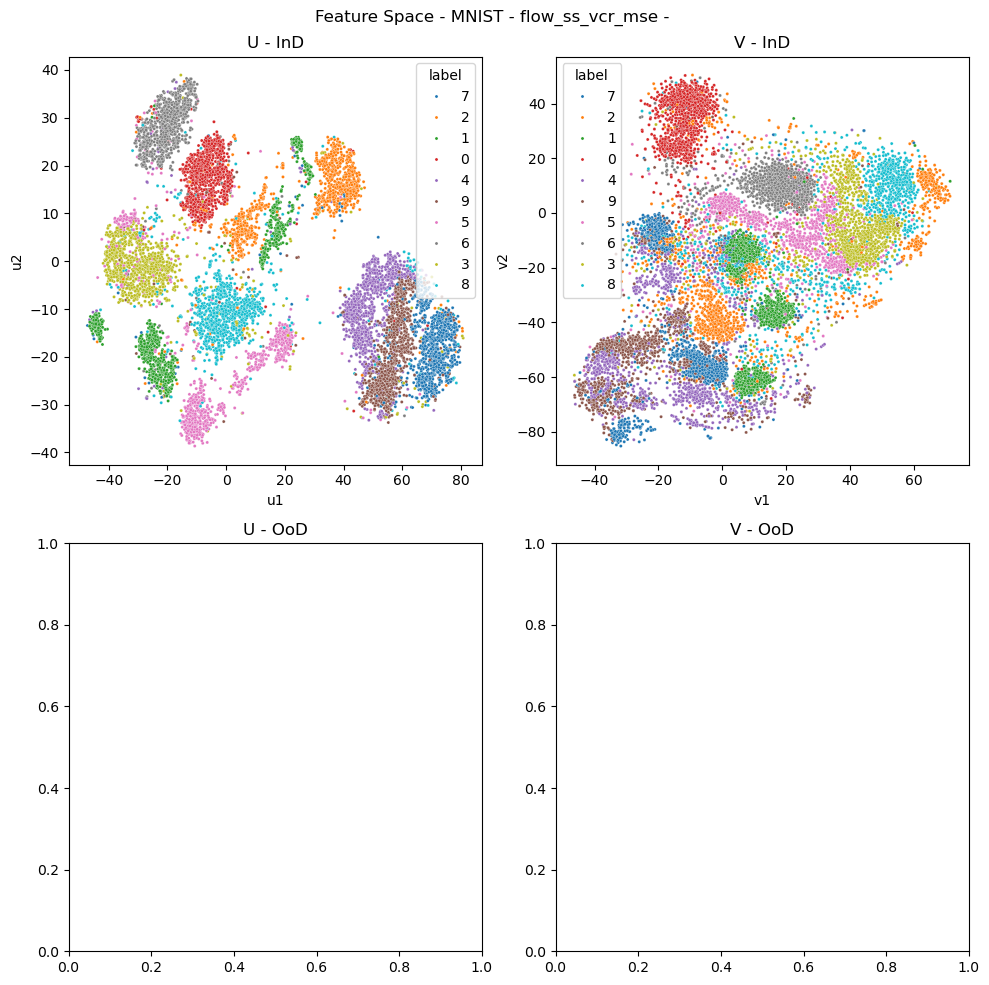

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
emb_data = pd.DataFrame()
u1, u2 = ind_e_u2d.T
v1, v2 = ind_e_v2d.T
emb_data = pd.concat([emb_data, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ind_labels, source="ind"))])

if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]
    u1, u2 = ood_e_u2d.T
    v1, v2 = ood_e_v2d.T
    emb_data = pd.concat([emb_data, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ood_labels, source="ood"))])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
ax1.set_title("U - InD")
ax2.set_title("V - InD")
ax3.set_title("U - OoD")
ax4.set_title("V - OoD")

sns.scatterplot(data=emb_data[(emb_data['source'] == "ind")], x="u1", y="u2", hue="label", s=5, ax=ax1)
sns.scatterplot(data=emb_data[(emb_data['source'] == "ind")], x="v1", y="v2", hue="label", s=5, ax=ax2)
sns.scatterplot(data=emb_data[(emb_data['source'] == "ood")], x="u1", y="u2", hue="label", s=5, ax=ax3)
sns.scatterplot(data=emb_data[(emb_data['source'] == "ood")], x="v1", y="v2", hue="label", s=5, ax=ax4)

plt.tight_layout()
plt.show()

  0%|                                                                                                           | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████▊                                                                          | 1/4 [00:00<00:01,  1.86it/s]

 50%|█████████████████████████████████████████████████▌                                                 | 2/4 [00:01<00:01,  1.99it/s]

 75%|██████████████████████████████████████████████████████████████████████████▎                        | 3/4 [00:01<00:00,  1.98it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.90it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.92it/s]

  0%|                                                                                                           | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████▊                                                                          | 1/4 [00:01<00:03,  1.09s/it]

 50%|█████████████████████████████████████████████████▌                                                 | 2/4 [00:02<00:02,  1.10s/it]

 75%|██████████████████████████████████████████████████████████████████████████▎                        | 3/4 [00:03<00:01,  1.12s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.15s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.13s/it]

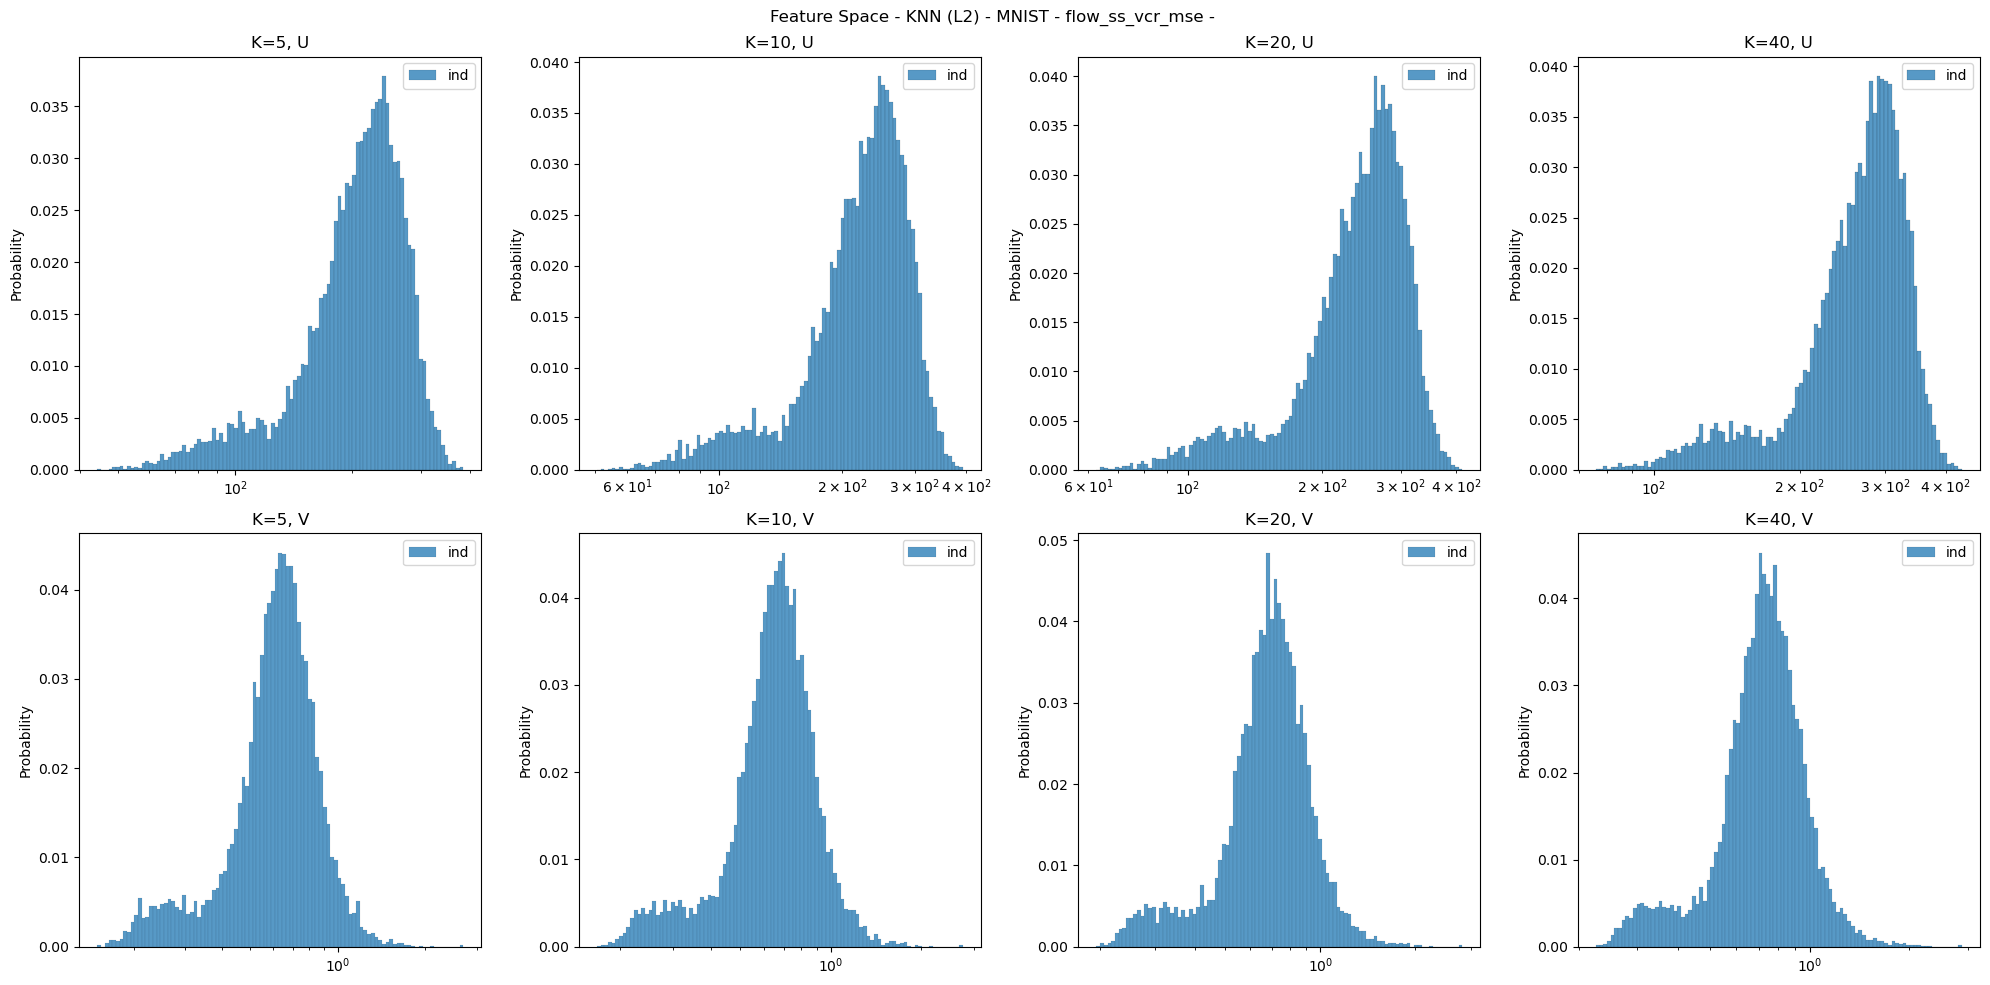

In [14]:
import faiss

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

index_e_u = faiss.IndexFlatL2(ind_e_u.shape[-1])
index_e_u.add(ind_e_u)
for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_e_u.search(ind_e_u, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_e_u.search(ood_e_u, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[0][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, U")
    ax.set_xscale('log')
    ax.legend()

index_e_v = faiss.IndexFlatL2(ind_e_v.shape[-1])
index_e_v.add(ind_e_v)
for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_e_v.search(ind_e_v, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_e_v.search(ood_e_v, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[1][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, V")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                           | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████▊                                                                          | 1/4 [00:00<00:01,  1.62it/s]

 50%|█████████████████████████████████████████████████▌                                                 | 2/4 [00:01<00:01,  1.89it/s]

 75%|██████████████████████████████████████████████████████████████████████████▎                        | 3/4 [00:01<00:00,  1.96it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.91it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.89it/s]

  0%|                                                                                                           | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████▊                                                                          | 1/4 [00:01<00:03,  1.07s/it]

 50%|█████████████████████████████████████████████████▌                                                 | 2/4 [00:02<00:02,  1.08s/it]

 75%|██████████████████████████████████████████████████████████████████████████▎                        | 3/4 [00:03<00:01,  1.09s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.12s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.10s/it]

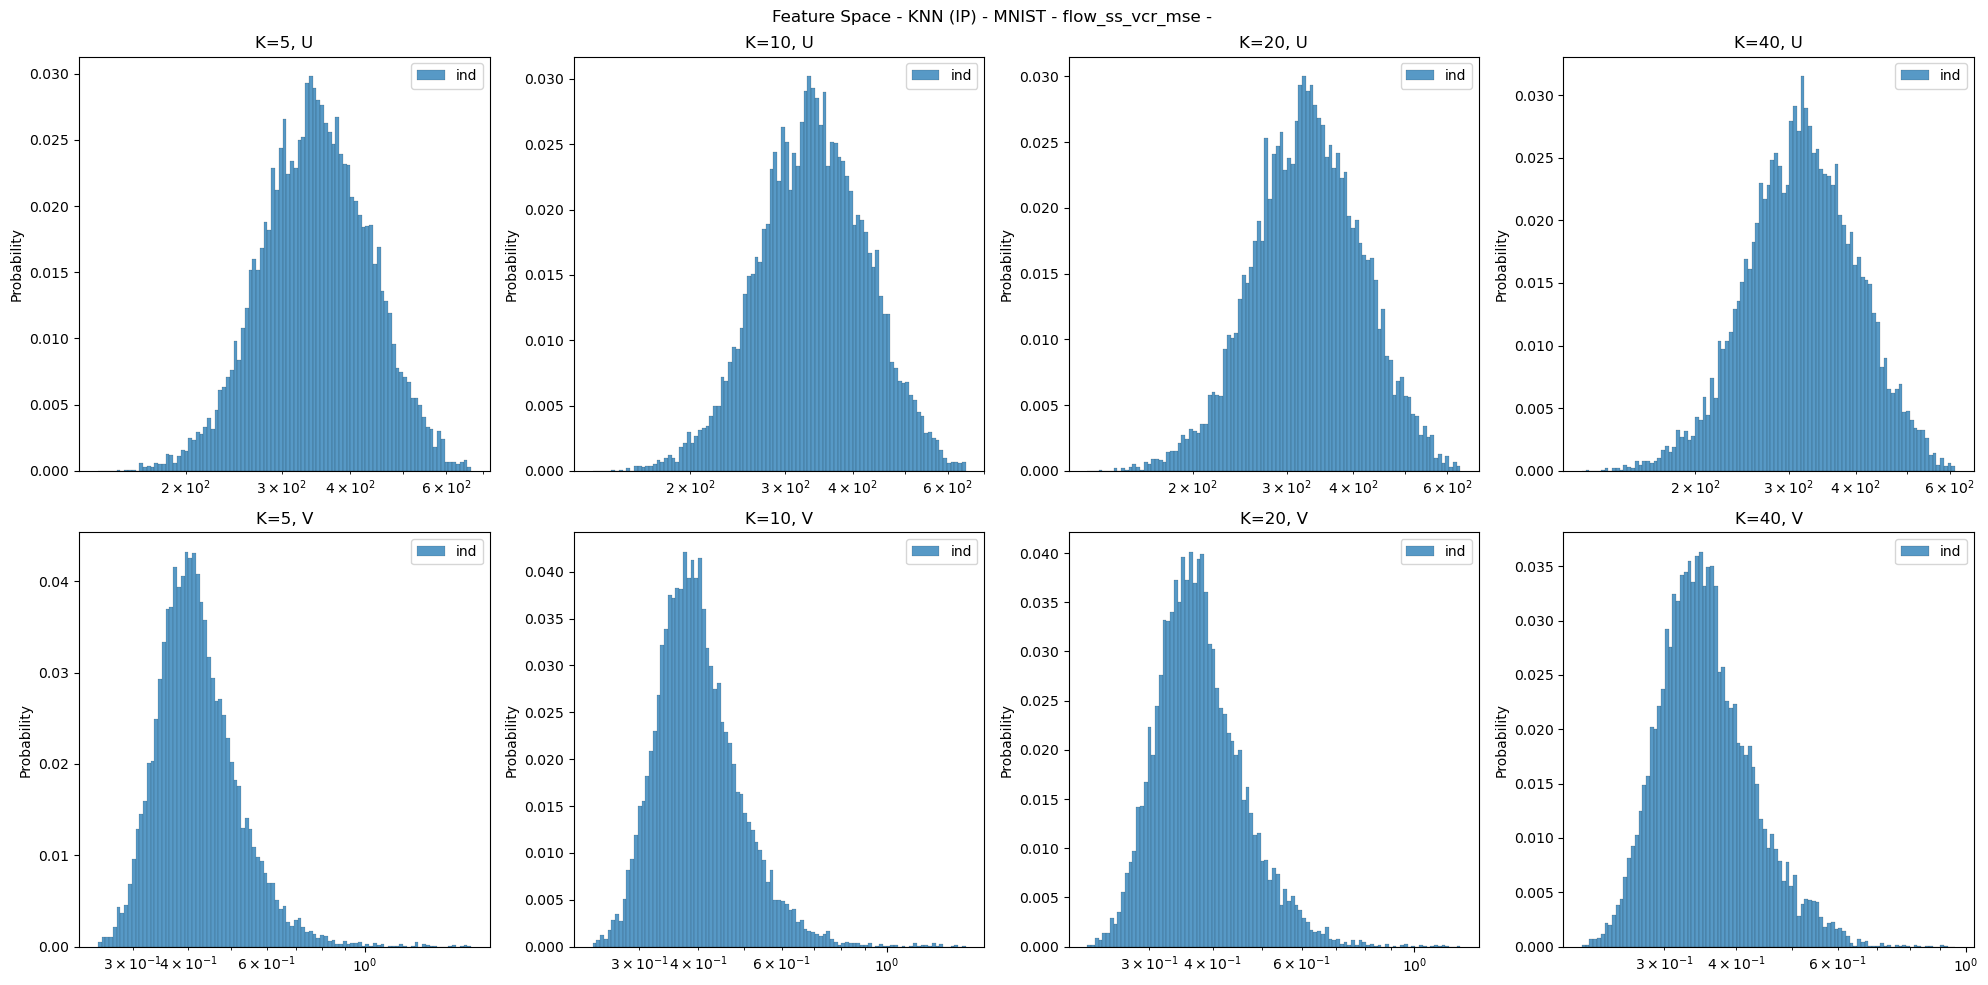

In [15]:
import faiss

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

index_e_u = faiss.IndexFlatIP(ind_e_u.shape[-1])
index_e_u.add(ind_e_u)
for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_e_u.search(ind_e_u, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_e_u.search(ood_e_u, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[0][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, U")
    ax.set_xscale('log')
    ax.legend()

index_e_v = faiss.IndexFlatIP(ind_e_v.shape[-1])
index_e_v.add(ind_e_v)
for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_e_v.search(ind_e_v, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_e_v.search(ood_e_v, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[1][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, V")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

In [16]:
from scipy.linalg import norm

trn_n_u = norm(trn_e_u, axis=-1)
trn_n_v = norm(trn_e_v, axis=-1)
val_n_u = norm(val_e_u, axis=-1)
val_n_v = norm(val_e_v, axis=-1)
ind_n_u = norm(ind_e_u, axis=-1)
ind_n_v = norm(ind_e_v, axis=-1)
if ood_str:
    ood_n_u = norm(ood_e_u, axis=-1)
    ood_n_v = norm(ood_e_v, axis=-1)
rnd_n_u = norm(rnd_e_u, axis=-1)
rnd_n_v = norm(rnd_e_v, axis=-1)

print(trn_n_u.mean(), trn_n_u.std(), trn_n_v.mean(), trn_n_v.std())
print(val_n_u.mean(), val_n_u.std(), val_n_v.mean(), val_n_v.std())
print(ind_n_u.mean(), ind_n_u.std(), ind_n_v.mean(), ind_n_v.std())
if ood_str:
    print(ood_n_u.mean(), ood_n_u.std(), ood_n_v.mean(), ood_n_v.std())
print(rnd_n_u.mean(), rnd_n_u.std(), rnd_n_v.mean(), rnd_n_v.std())

20.764647 2.0693614 0.864765 0.115113445
20.71137 2.0542915 0.8673711 0.116542354
20.851254 2.056781 0.86098164 0.11206257
34.584736 2.1227891 26.533218 0.7996888


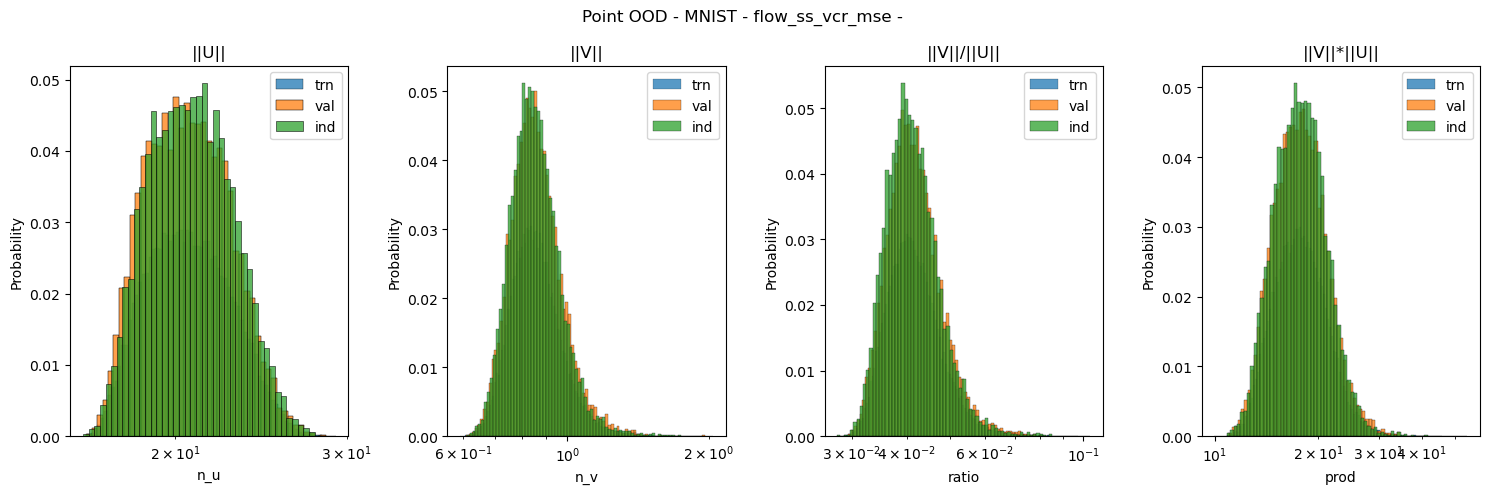

In [17]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

df_trn = pd.DataFrame(dict(n_u=trn_n_u, n_v=trn_n_v, ratio=trn_n_v/trn_n_u, prod=trn_n_v*trn_n_u, target=trn_tgt))
df_val = pd.DataFrame(dict(n_u=val_n_u, n_v=val_n_v, ratio=val_n_v/val_n_u, prod=val_n_v*val_n_u, target=val_tgt))
df_ind = pd.DataFrame(dict(n_u=ind_n_u, n_v=ind_n_v, ratio=ind_n_v/ind_n_u, prod=ind_n_v*ind_n_u, target=ind_tgt))
if ood_str:
    df_ood = pd.DataFrame(dict(n_u=ood_n_u, n_v=ood_n_v, ratio=ood_n_v/ood_n_u, prod=ood_n_v*ood_n_u, target=ood_tgt))
df_rnd = pd.DataFrame(dict(n_u=rnd_n_u, n_v=rnd_n_v, ratio=rnd_n_v/rnd_n_u, prod=rnd_n_v*rnd_n_u))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 5))
fig.suptitle(f"Point OOD - {dataset_name} - {model_name} - {ood_str}")

def plot_row(prop, ax):
    sns.histplot(data=df_trn, x=prop, log_scale=True, fill=True, label='trn', stat='probability', ax=ax)
    sns.histplot(data=df_val, x=prop, log_scale=True, fill=True, label='val', stat='probability', ax=ax)
    sns.histplot(data=df_ind, x=prop, log_scale=True, fill=True, label='ind', stat='probability', ax=ax)
    if ood_str:
        sns.histplot(data=df_ood, x=prop, log_scale=True, fill=True, label='ood', stat='probability', ax=ax)
    # sns.histplot(data=df_rnd, x=prop, log_scale=True, fill=True, label='rnd', stat='density', ax=ax)
    ax.legend()

plot_row("n_u", ax1)
plot_row("n_v", ax2)
plot_row("ratio", ax3)
plot_row("prod", ax4)
ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.tight_layout()
plt.show()

In [18]:
if ood_str:
    df_tst = pd.concat([df_ind, df_ood], axis=0)
else:
    df_tst = df_ind

all_targets = list(df_tst['target'].unique())
K = len(all_targets)
N = 128
rw, rh = 2, 0.75
colors = sns.color_palette(n_colors=K)

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(K):
    _trn = df_trn[df_trn['target'] == all_targets[i]]
    _val = df_val[df_val['target'] == all_targets[i]]
    _tst = df_tst[df_tst['target'] == all_targets[i]]
    pointwise_trn[i] = _trn.copy()
    pointwise_val[i] = _val.copy()
    pointwise_tst[i] = _tst.copy()
    groupwise_trn[i] = _trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = _val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = _tst.rolling(N).agg(['mean', 'std']).dropna().copy()


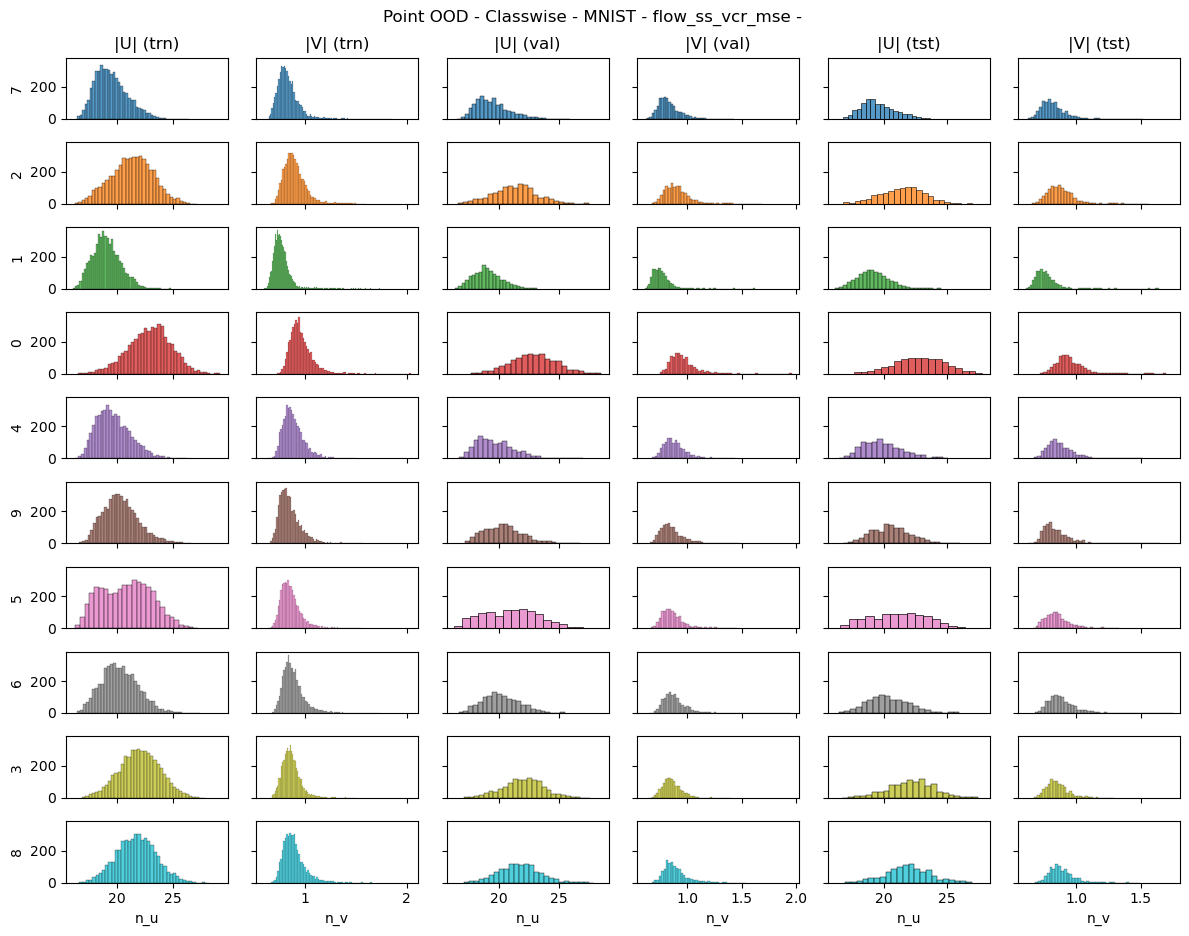

In [19]:
# pointwise
fig, axs = plt.subplots(K, 6, figsize=(6*rw, K*rh+2), sharex='col', sharey='all')
fig.suptitle(f"Point OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in range(K):
    _trn = pointwise_trn[i]
    _val = pointwise_val[i]
    _tst = pointwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn, x="n_u", fill=True, legend=False, color=_hue, ax=ax1)
        sns.histplot(data=_trn, x="n_v", fill=True, legend=False, color=_hue, ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val, x="n_u", fill=True, legend=False, color=_hue, ax=ax3)
        sns.histplot(data=_val, x="n_v", fill=True, legend=False, color=_hue, ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst, x="n_u", fill=True, legend=False, color=_hue, ax=ax5)
        sns.histplot(data=_tst, x="n_v", fill=True, legend=False, color=_hue, ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

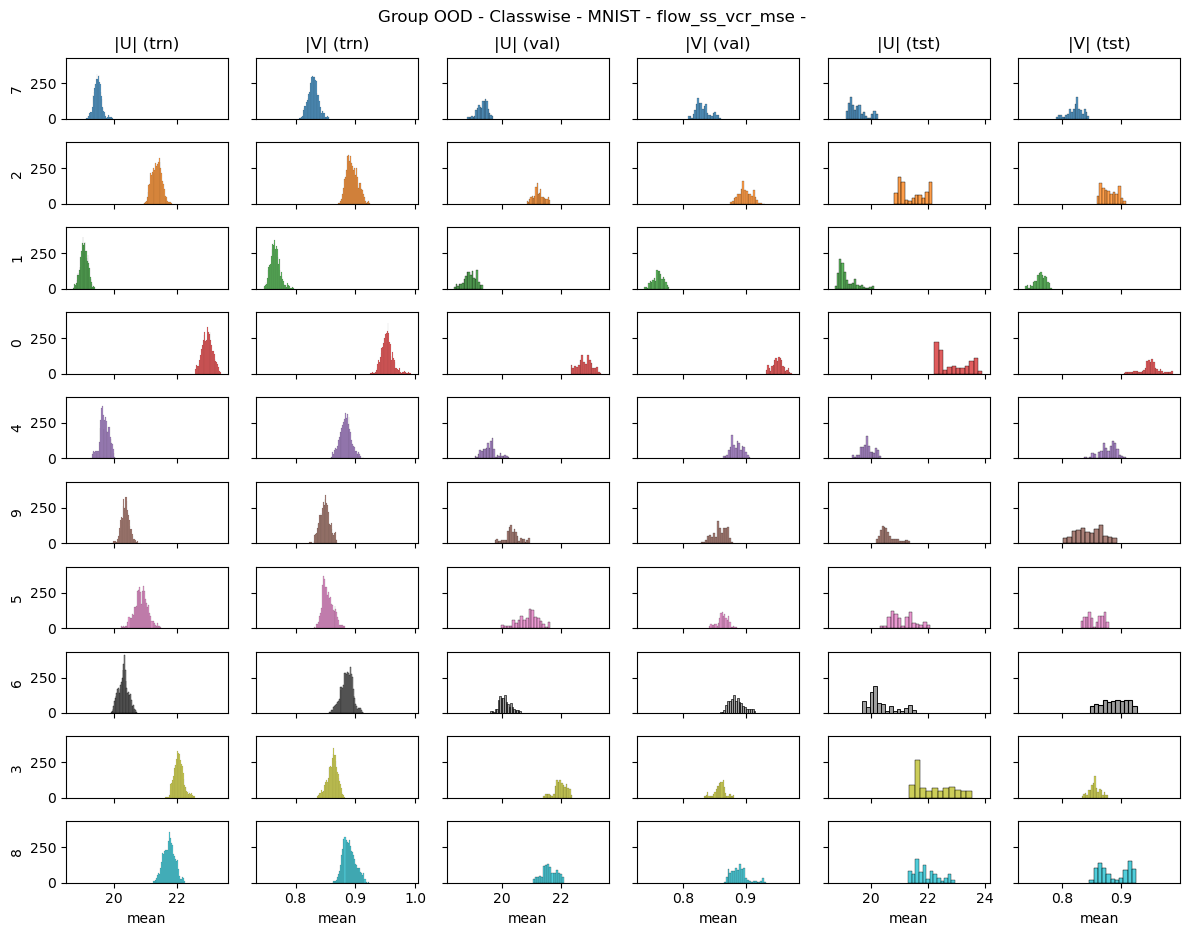

In [20]:
# groupwise
fig, axs = plt.subplots(K, 6, figsize = (6*rw, K*rh+2), sharex='col', sharey='all')
fig.suptitle(f"Group OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in all_targets:
    _trn = groupwise_trn[i]
    _val = groupwise_val[i]
    _tst = groupwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn.n_u, x="mean", fill=True, legend=False, color=_hue, ax=ax1)
        sns.histplot(data=_trn.n_v, x="mean", fill=True, legend=False, color=_hue, ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val.n_u, x="mean", fill=True, legend=False, color=_hue, ax=ax3)
        sns.histplot(data=_val.n_v, x="mean", fill=True, legend=False, color=_hue, ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst.n_u, x="mean", fill=True, legend=False, color=_hue, ax=ax5)
        sns.histplot(data=_tst.n_v, x="mean", fill=True, legend=False, color=_hue, ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()